# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



# Ник на kaggle
Alexey_Shulmin_136419481

### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np
import os

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
print(PIL.__version__)

10.2.0


In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [4]:
# !tar -xf journey-springfield.zip

In [6]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Apr 18 17:31:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.76                 Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              6W /   75W |    1249MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [7]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tempfile import TemporaryDirectory

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [8]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [30]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        try:
            x = transform(x)
        except Exception:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [12]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [13]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [15]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

In [16]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        for param in model.parameters():
            param.grad = None

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [17]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [113]:
def train(train_files, val_files, model, epochs, batch_size, train_weights, val_weights):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        with tqdm(desc="epoch", total=epochs) as pbar_outer:
            opt = torch.optim.AdamW(model.parameters(), lr=0.0001)
            scheduler = ReduceLROnPlateau(opt, mode='max', patience=2)
    
            for epoch in range(epochs):
                criterion = nn.CrossEntropyLoss(weight=train_weights).cuda()
                train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
                print("loss", train_loss)

                criterion = nn.CrossEntropyLoss(weight=val_weights).cuda()
                val_loss, val_acc = eval_epoch(model, val_loader, criterion)
                history.append((train_loss, train_acc, val_loss, val_acc))
                
                if val_acc > best_acc:
                    best_acc = val_acc
                    torch.save(model.state_dict(), best_model_params_path)

                pbar_outer.update(1)
                tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                               v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
                scheduler.step(val_acc)
        model.load_state_dict(torch.load(best_model_params_path))

    return history

In [19]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим обучение сети.

In [32]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [35]:
train_weights = np.zeros(42, dtype=np.float16)
val_weights = np.zeros(42, dtype=np.float16)
for _, label in train_dataset:
    train_weights[label] += 1
for _, label in val_dataset:
    val_weights[label] += 1
train_weights = len(train_dataset) / train_weights
val_weights = len(val_dataset) / val_weights
train_weights = torch.tensor(train_weights, dtype=torch.float32, device='cuda')
val_weights = torch.tensor(val_weights, dtype=torch.float32, device='cuda')
train_weights, val_weights

C:\Users\Алексей\AppData\Local\Temp\ipykernel_16812\325473637.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_weights = torch.tensor(train_weights, dtype=torch.float32, device='cuda')
C:\Users\Алексей\AppData\Local\Temp\ipykernel_16812\325473637.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_weights = torch.tensor(val_weights, dtype=torch.float32, device='cuda')


(tensor([  38.3276,  490.5938,   38.3276,  196.2375,   38.3276,  212.1487,
           38.3276,   38.3276,  448.5428,   44.5994, 2616.5000,   45.7697,
          784.9500,  784.9500,  172.5165,   38.3276,   42.0885,   38.3276,
           67.3777, 7849.5000,   38.3276,  163.5312,   38.3276,  296.2076,
           84.8595,   38.3276, 1207.6154,   38.3276,   38.3276,   58.3606,
          654.1250,  290.7222,   38.3276,  320.3878,  461.7353,  234.3134,
          203.8831,   38.3276,  523.3000,  382.9024, 2616.5000,  115.4338],
        device='cuda:0'),
 tensor([  22.9561,  523.4000,   33.5513,  201.3077,   15.5774,  218.0833,
           17.5638,   21.1903,  436.1667,   44.7350, 2617.0000,   45.9123,
          747.7143,  747.7143,  174.4667,    9.3132,   41.8720,   17.3311,
           67.9740, 5234.0000,   15.4395,  163.5625,   16.2043,  290.7778,
           85.8033,   19.3852, 1308.5000,   14.4187,   14.3791,   58.8090,
          654.2500,  290.7778,   17.5050,  327.1250,  475.8182,  237.9091

In [129]:
from torchvision import models

my_net = models.resnet50(weights='IMAGENET1K_V2')

In [130]:
my_net.fc = nn.Linear(in_features=2048, out_features=42, bias=True)
my_net = my_net.to(DEVICE)

In [131]:
history = train(train_dataset, val_dataset, model=my_net, epochs=10, batch_size=64, train_weights=train_weights, val_weights=val_weights)

epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

loss 1.8975404868521382


epoch:  10%|███████▏                                                                | 1/10 [50:46<7:36:58, 3046.53s/it]


Epoch 001 train_loss: 1.8975     val_loss 0.4712 train_acc 0.6834 val_acc 0.9268
loss 0.2989427008015258


epoch:  20%|██████████████                                                        | 2/10 [1:40:01<6:38:59, 2992.47s/it]


Epoch 002 train_loss: 0.2989     val_loss 0.2132 train_acc 0.9586 val_acc 0.9543
loss 0.0764735259066576


epoch:  30%|█████████████████████                                                 | 3/10 [2:29:14<5:47:02, 2974.61s/it]


Epoch 003 train_loss: 0.0765     val_loss 0.1251 train_acc 0.9865 val_acc 0.9729
loss 0.023089398773586046


epoch:  40%|████████████████████████████                                          | 4/10 [3:18:28<4:56:37, 2966.33s/it]


Epoch 004 train_loss: 0.0231     val_loss 0.1234 train_acc 0.9962 val_acc 0.9752
loss 0.009924444217747169


epoch:  50%|███████████████████████████████████                                   | 5/10 [4:07:45<4:06:55, 2963.05s/it]


Epoch 005 train_loss: 0.0099     val_loss 0.1085 train_acc 0.9982 val_acc 0.9776
loss 0.005680587794480444


epoch:  60%|██████████████████████████████████████████                            | 6/10 [4:57:07<3:17:31, 2962.78s/it]


Epoch 006 train_loss: 0.0057     val_loss 0.1143 train_acc 0.9989 val_acc 0.9778
loss 0.0035899644768592493


epoch:  70%|█████████████████████████████████████████████████                     | 7/10 [5:48:04<2:29:40, 2993.60s/it]


Epoch 007 train_loss: 0.0036     val_loss 0.1059 train_acc 0.9991 val_acc 0.9801
loss 0.0024527859186893753


epoch:  80%|████████████████████████████████████████████████████████              | 8/10 [6:37:41<1:39:36, 2988.29s/it]


Epoch 008 train_loss: 0.0025     val_loss 0.1092 train_acc 0.9992 val_acc 0.9797
loss 0.0017281873193928092


epoch:  90%|████████████████████████████████████████████████████████████████▊       | 9/10 [7:26:22<49:27, 2967.22s/it]


Epoch 009 train_loss: 0.0017     val_loss 0.1247 train_acc 0.9995 val_acc 0.9763
loss 0.002335844158471823


epoch: 100%|███████████████████████████████████████████████████████████████████████| 10/10 [8:14:41<00:00, 2968.13s/it]


Epoch 010 train_loss: 0.0023     val_loss 0.1229 train_acc 0.9993 val_acc 0.9790


Построим кривые обучения

In [132]:
loss, acc, val_loss, val_acc = zip(*history)

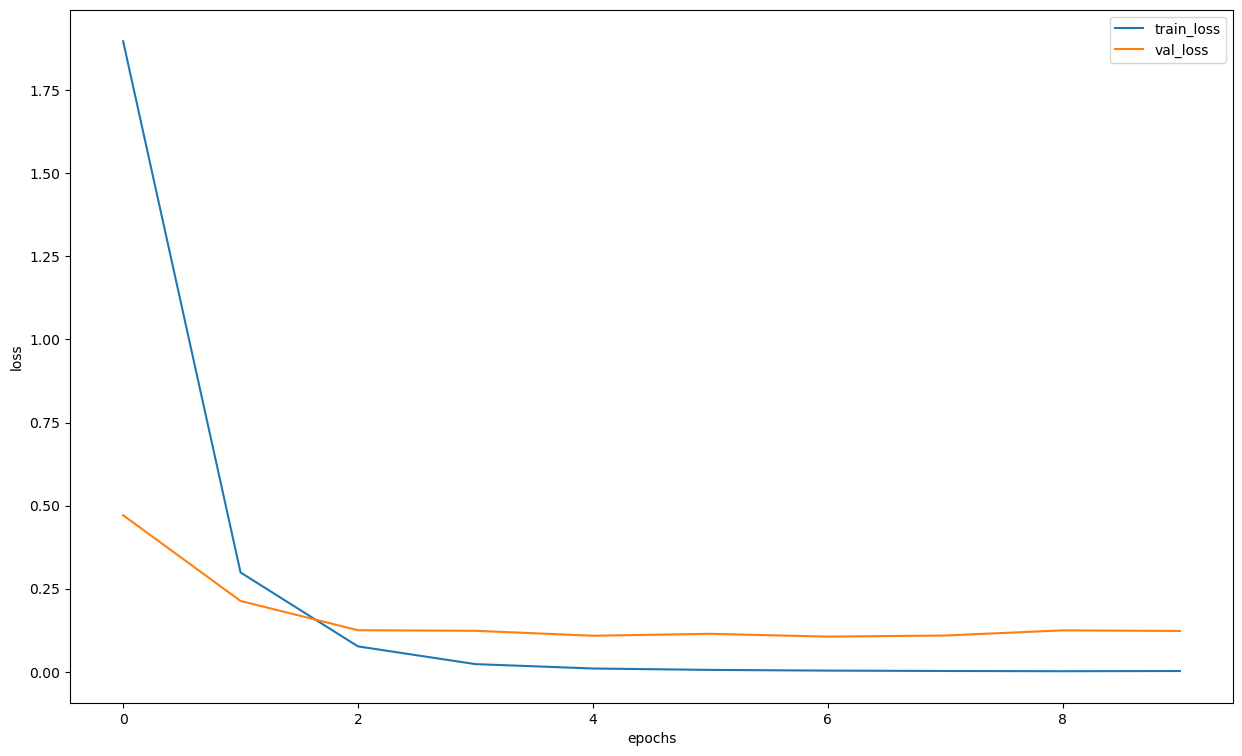

In [134]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [135]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [136]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(my_net, ex_img.unsqueeze(0))

In [137]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(my_net, imgs)

In [138]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [139]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [140]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.9


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

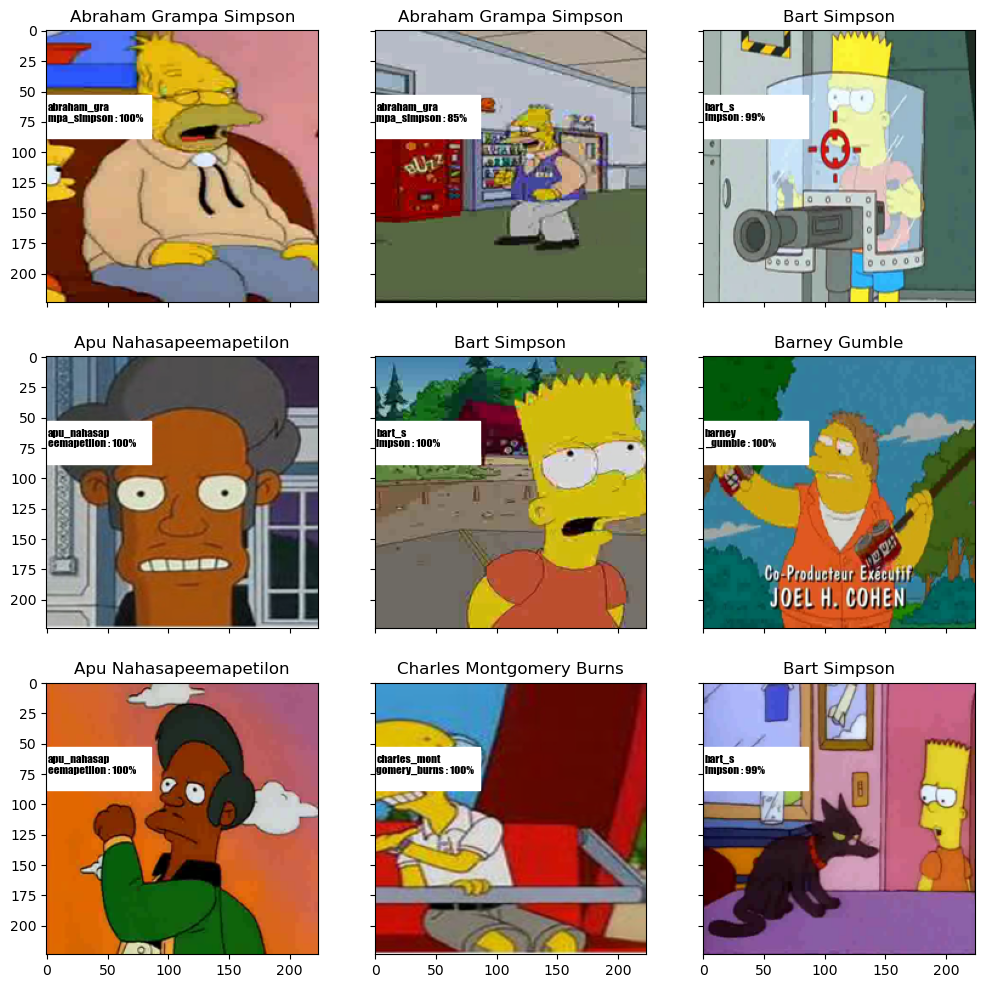

In [141]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(my_net, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [142]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(my_net, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [143]:
! ls

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [144]:
import pandas as pd
# my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [145]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [147]:
my_submit.to_csv('submit.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
